In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

paper_folder_path = "../results/paper"

apple_m3_pro_folder_path = os.path.join(paper_folder_path, "apple-m3-pro")
apple_m3_pro_contents = os.listdir(apple_m3_pro_folder_path)
gcp_linux_folder_path = os.path.join(paper_folder_path, "gcp-linux")
gcp_linux_contents = os.listdir(gcp_linux_folder_path)
apple_m3_pro_folder_path = os.path.join(paper_folder_path, "apple-m3-pro")
apple_m3_pro_contents = os.listdir(apple_m3_pro_folder_path)
gcp_linux_folder_path = os.path.join(paper_folder_path, "gcp-linux")
gcp_linux_contents = os.listdir(gcp_linux_folder_path)
apple_m3_pro_contents, gcp_linux_contents
apple_m3_pro_8_7_folder_path = os.path.join(apple_m3_pro_folder_path, "8-7")
apple_m3_pro_8_7_parallel_folder_path = os.path.join(apple_m3_pro_folder_path, "8-7-parallel")
apple_m3_pro_8_7_contents = os.listdir(apple_m3_pro_8_7_folder_path)
apple_m3_pro_8_7_parallel_contents = os.listdir(apple_m3_pro_8_7_parallel_folder_path)
apple_m3_pro_1_2_folder_path = os.path.join(apple_m3_pro_folder_path, "1-2")
apple_m3_pro_7_8_folder_path = os.path.join(apple_m3_pro_folder_path, "7-8")
gcp_linux_1_2_folder_path = os.path.join(gcp_linux_folder_path, "1-2")
gcp_linux_7_8_folder_path = os.path.join(gcp_linux_folder_path, "7-8")
apple_m3_pro_1_2_contents = os.listdir(apple_m3_pro_1_2_folder_path)
apple_m3_pro_7_8_contents = os.listdir(apple_m3_pro_7_8_folder_path)
gcp_linux_1_2_contents = os.listdir(gcp_linux_1_2_folder_path)
gcp_linux_7_8_contents = os.listdir(gcp_linux_7_8_folder_path)

# Load CSV files for macOS (Apple M3 Pro) and Linux (GCP)
def load_benchmark_data(folder_path, dataset):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    data = {}
    
    for op in operations:
        file_path = os.path.join(folder_path, f"{op}_{dataset}.csv")
        if os.path.exists(file_path):
            data[op] = pd.read_csv(file_path)
    
    return data

# Load data for dataset comparisons 1-2 and 7-8 (both platforms)
macos_1_2_data = load_benchmark_data(apple_m3_pro_1_2_folder_path, "1-2")
macos_7_8_data = load_benchmark_data(apple_m3_pro_7_8_folder_path, "7-8")
macos_8_7_data = load_benchmark_data(apple_m3_pro_8_7_folder_path, "8-7")
linux_1_2_data = load_benchmark_data(gcp_linux_1_2_folder_path, "1-2")
linux_7_8_data = load_benchmark_data(gcp_linux_7_8_folder_path, "7-8")

# Load data for 8-7 scalability analysis (macOS)
macos_8_7_parallel_data = load_benchmark_data(apple_m3_pro_8_7_parallel_folder_path, "8-7")



In [48]:

def compute_speedup_with_error(macos_data):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    ordered_libraries = ["polars_bio", "pyranges0", "pyranges1", "bioframe", "pybedtools", "genomicranges"]
    speedup_data = {'Library': [], 'Operation': [], 'Speedup': [], 'Error': []}

    for op in operations:
        if op in macos_data:
            macos_df = macos_data[op]
            # Extract bioframe execution time stats (baseline)
            bioframe_row = macos_df[macos_df['Library'] == 'bioframe']
            if bioframe_row.empty:
                continue  # Skip if no bioframe data
            mean_bioframe = bioframe_row['Mean (s)'].values[0]
            std_bioframe = (bioframe_row['Max (s)'].values[0] - bioframe_row['Min (s)'].values[0]) / 2
            for lib in ordered_libraries:
                tool_row = macos_df[macos_df['Library'] == lib]
                if tool_row.empty:
                    speedup_data['Library'].append(lib)
                    speedup_data['Operation'].append(op)
                    speedup_data['Speedup'].append(None)
                    speedup_data['Error'].append(None)
                else:
                    mean_tool = tool_row['Mean (s)'].values[0]
                    std_tool = (tool_row['Max (s)'].values[0] - tool_row['Min (s)'].values[0]) / 2
                    speedup = mean_bioframe / mean_tool

                    speedup_error = speedup * np.sqrt(
                        (std_bioframe / mean_bioframe) ** 2 + (std_tool / mean_tool) ** 2
                    )

                    speedup_data['Library'].append(lib)
                    speedup_data['Operation'].append(op)
                    speedup_data['Speedup'].append(speedup)
                    speedup_data['Error'].append(speedup_error)

    return pd.DataFrame(speedup_data)


def plot_speedup(speedup_df, dataset, operating_system):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    ordered_libraries = ["polars_bio", "pyranges0", "pyranges1", "bioframe", "pybedtools", "genomicranges"]

    grayscale_patterns = ['gray', 'black', 'dimgray', 'silver']

    plt.figure(figsize=(10, 5))
    x = np.arange(len(ordered_libraries))
    width = 0.15  # Width of each bar

    for i, (op, color) in enumerate(zip(operations, grayscale_patterns)):
        subset = speedup_df[speedup_df['Operation'] == op]
        plt.bar(
            x + i * width,
            subset['Speedup'],
            width=width,
            label=op,
            color=color,
            edgecolor='black',
            yerr=subset['Error'],
            capsize=5,
            ecolor='black',
            error_kw={'elinewidth': 1.5, 'capsize': 3}
        )

    plt.xlabel("Library")
    plt.ylabel("Speedup (relative to bioframe)")
    plt.title(f"Speedup Across Operations (Dataset {dataset}, {operating_system})")
    plt.xticks(x + width, ordered_libraries, rotation=45, ha="right")
    plt.legend(title="Operation")
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.show()




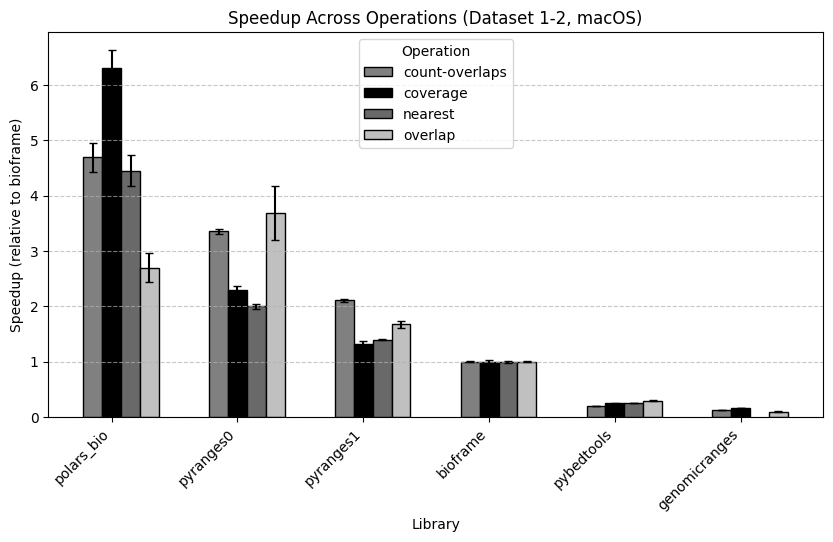

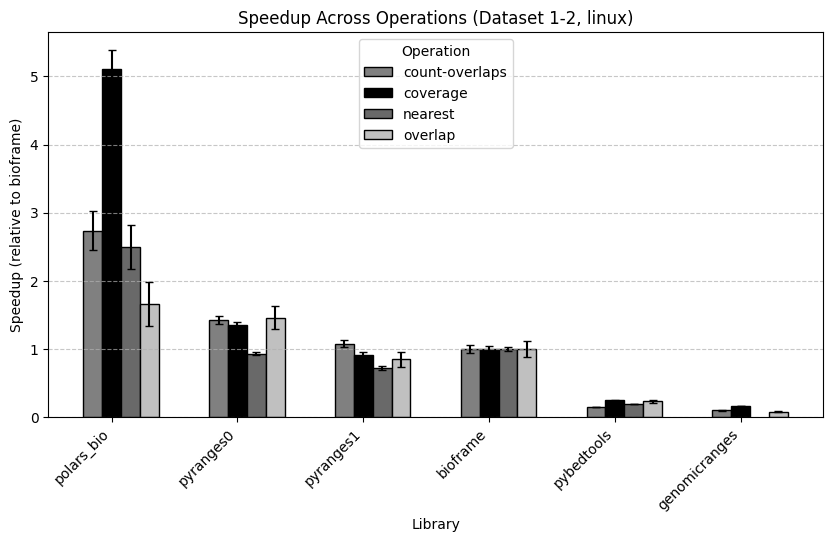

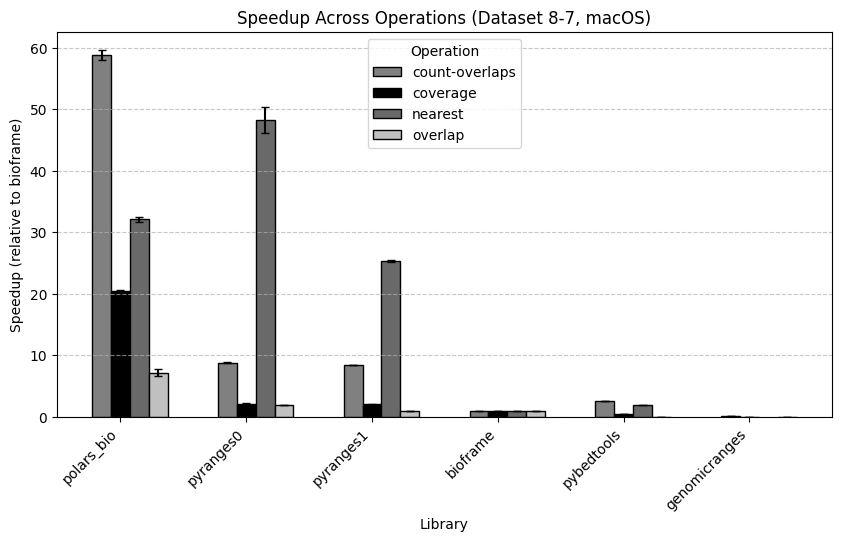

In [49]:
corrected_speedup_df = compute_speedup_with_error(macos_1_2_data)
plot_speedup(corrected_speedup_df, "1-2", "macOS")
corrected_speedup_df = compute_speedup_with_error(linux_1_2_data)
plot_speedup(corrected_speedup_df, "1-2", "linux")
corrected_speedup_df_8_7 = compute_speedup_with_error(macos_8_7_data)
plot_speedup(corrected_speedup_df_8_7, "8-7", "macOS")


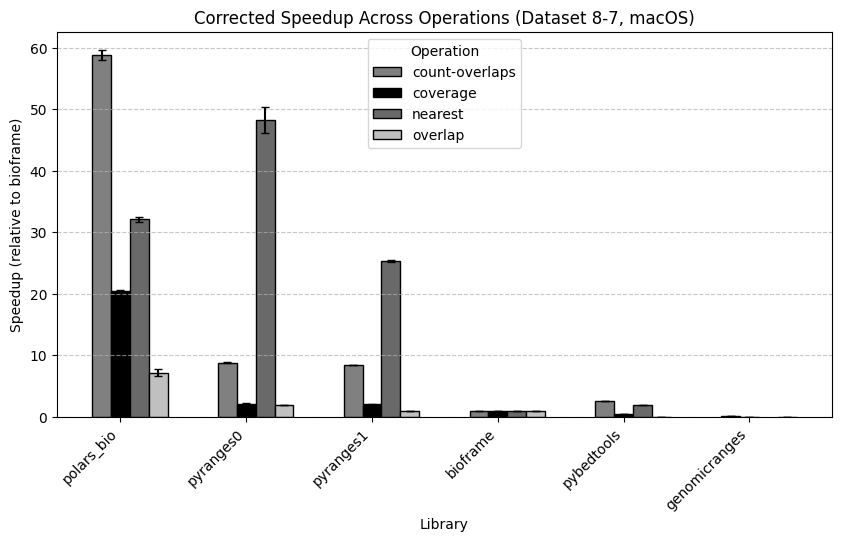

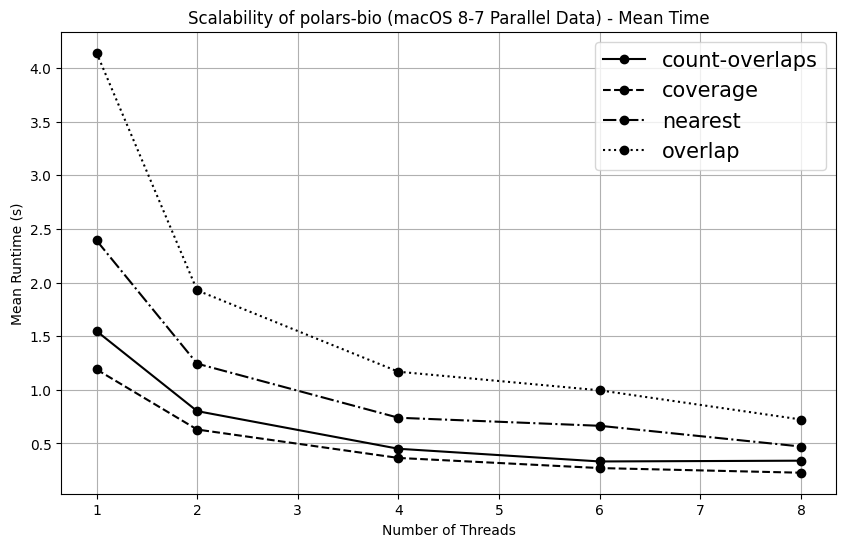

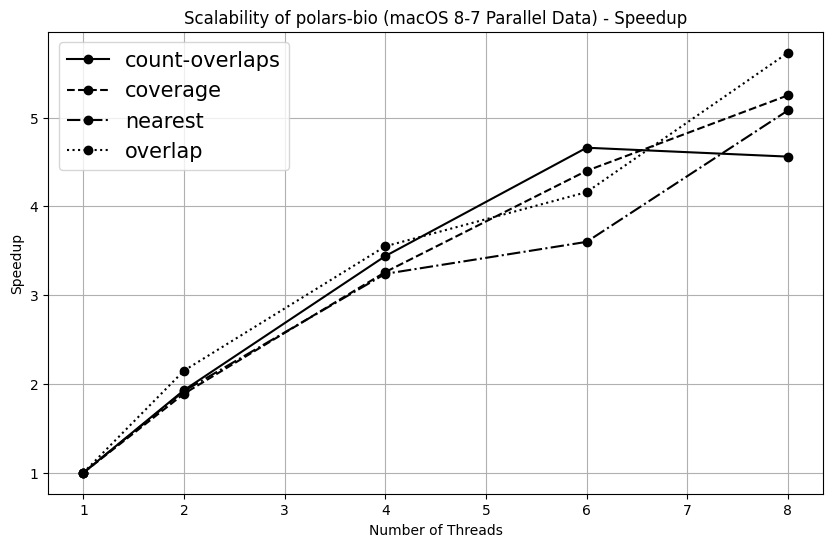

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def extract_threads(library_name):
    if library_name == "polars_bio":
        return 1
    else:
        parts = library_name.split("-")
        if len(parts) > 1:
            try:
                return int(parts[1])
            except ValueError:
                return None
        return None

def plot_scalability(metric="speedup"):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    line_styles = ['-', '--', '-.', ':']
    
    plt.figure(figsize=(10, 6))
    for idx, op in enumerate(operations):
        if op in macos_8_7_parallel_data:
            data = macos_8_7_parallel_data[op].copy()
            data['threads'] = data['Library'].apply(extract_threads)
            data = data.sort_values('threads')
            if metric.lower() == "speedup":
                data['Speedup'] = data['Speedup'].str.rstrip('x').astype(float)
                y = data['Speedup']
            else:
                y = data["Mean (s)"]
                
            plt.plot(data['threads'], y, linestyle=line_styles[idx % len(line_styles)],
                     marker='o', color='black', label=op)
    
    if metric.lower() == "speedup":
        y_label = "Speedup"
        title = "Scalability of polars-bio (macOS 8-7 Parallel Data) - Speedup"
    else:
        y_label = "Mean Runtime (s)"
        title = "Scalability of polars-bio (macOS 8-7 Parallel Data) - Mean Time"
    
    plt.xlabel("Number of Threads")
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(np.arange(1, 9, 1))
    plt.legend(fontsize=15)  # Enlarged legend font size
    plt.grid(True)
    plt.show()

plot_scalability(metric="time")
plot_scalability(metric="speedup")
